In [1]:
import numpy as np

from utils import *
from generate_data import * 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

from network import *

from plot_data import *
from data_loading import *

import json

from gaussian_predictor_levelsets import *
from gaussian_predictor_likelihood import *
from gaussian_trainer import *
from covariances import *
from MVCS import *
from OT_predictor import *

seed_everything(42)

In [ ]:
seed_everything(42)

class RadiusTransformation2:
    def __init__(self, d, beta=None):
        if beta is None:
            beta = np.random.randn(d)
        self.beta = beta

    def get(self, x):
        return ((( np.linalg.norm(x)) / 2.0 + (np.dot(self.beta, x))**2 / 10) / 2 ) / .5 + 0.15
        return ( np.linalg.norm(x)) / 2.0 + np.exp(np.dot(self.beta, x))

d = 2
hidden_dim = 5
hidden_dim_matrix = 100
k = 2

tab_coverage = []
tab_warm_start_covariance_coverage = []
tab_warm_start_local_covariance_coverage = []
tab_hyper_rectangle_coverage = []

pert = "gaussian"

n_train = 20_000
n_test = 1_000
n_calibration = 1_000
n_stop = 1_000
n_anchors = 10



config_name = "exp_t"

config_path = "../parameters/" + config_name + ".json"

with open(config_path, 'r') as file : 
    parameters = json.load(file)



hidden_dim = parameters["hidden_dim"]
hidden_dim_matrix = parameters["hidden_dim_matrix"]
n_hidden_layers = parameters["n_hidden_layers"]
n_hidden_layers_matrix = parameters["n_hidden_layers_matrix"]


num_epochs = parameters["num_epochs"]

lr_center = parameters["lr_center"]   
lr_matrix = parameters["lr_matrix"]

batch_size = parameters["batch_size"]

use_lr_scheduler = parameters["use_lr_scheduler"]
keep_best = parameters["keep_best"] 

idx_knowned = np.array(parameters["idx_knowned"])

dtype = torch.float32 if parameters["dtype"] == "float32" else torch.float64

alpha = parameters["alpha"]
print(alpha)

class NonLinearFunction2:
    def __init__(self, d, k, beta=None):
        if beta is None:
            beta = np.random.randn(d, k)
        self.beta = beta
        self.proj  = np.zeros((d, k))
        self.proj[0, 0] = 1.0
        self.proj[1, 1] = 1.0

    def get(self, x):
        nonlinear_term = np.sin(np.dot(x, self.beta)) + 0.5 * np.tanh(np.dot(x**2, self.beta)) + np.dot(x, self.proj)
        return nonlinear_term * 2

f_star = NonLinearFunction2(d, k)
radius = RadiusTransformation2(d)
local_perturbation = LocalPerturbation(d, k, n_anchors=n_anchors, radius_transformation=radius)
data_generator = DataGenerator(d, k, pert, f_star=f_star, local_perturbation=local_perturbation, covariance_matrix=np.array([[1.0, 0.5],[0.5, 1.0]]), bias = False, seed = 42)

x_train, y_train = data_generator.generate(n_train)
x_stop, y_stop = data_generator.generate(n_stop)
x_calibration, y_calibration = data_generator.generate(n_calibration)
x_test, y_test = data_generator.generate(n_test)


x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_stop_tensor = torch.tensor(x_stop, dtype=torch.float32)
y_stop_tensor = torch.tensor(y_stop, dtype=torch.float32)
x_calibration_tensor = torch.tensor(x_calibration, dtype=torch.float32)
y_calibration_tensor = torch.tensor(y_calibration, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



0.1


In [5]:
seed_everything(42)

center_model = Network(d, k, hidden_dim=hidden_dim, n_hidden_layers=n_hidden_layers).to(dtype)
matrix_model = MatrixPredictor(d, k, k, hidden_dim=hidden_dim_matrix).to(dtype)

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor), batch_size= batch_size, shuffle=True)
stoploader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_stop_tensor, y_stop_tensor), batch_size= batch_size, shuffle=True)
calibrationloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_calibration_tensor, y_calibration_tensor), batch_size= batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor), batch_size= batch_size, shuffle=True)

gaussian_predictor = GaussianTrainer(center_model, matrix_model, dtype=dtype)

center_model.fit_and_plot(trainloader, 
                            stoploader, 
                            num_epochs, 
                            keep_best = True, 
                            lr = lr_center, 
                            verbose=False)

gaussian_predictor.fit(trainloader, 
                        stoploader, 
                        num_epochs = num_epochs,
                        lr_center_models = 0.0,
                        lr_matrix_models = lr_matrix,
                        use_lr_scheduler = use_lr_scheduler,
                        verbose = 1,
                        stop_on_best = keep_best
                        )

Epoch 0: Loss = 2.4154608249664307 - Stop Loss = 2.209136962890625 - Best Stop Loss = 2.209136962890625
Epoch 100: Loss = 0.31260043382644653 - Stop Loss = 0.33633512258529663 - Best Stop Loss = 0.30154749751091003
Epoch 200: Loss = 0.29407334327697754 - Stop Loss = 0.3215709328651428 - Best Stop Loss = 0.29808321595191956
Epoch 300: Loss = 0.2798248529434204 - Stop Loss = 0.2993970513343811 - Best Stop Loss = 0.2947681248188019
Epoch 400: Loss = 0.2824869155883789 - Stop Loss = 0.30507907271385193 - Best Stop Loss = 0.2937677502632141
Epoch 500: Loss = 0.27684199810028076 - Stop Loss = 0.3039783835411072 - Best Stop Loss = 0.2922298312187195
Epoch 600: Loss = 0.2741181254386902 - Stop Loss = 0.3004339635372162 - Best Stop Loss = 0.2905193865299225
Epoch 700: Loss = 0.2726849615573883 - Stop Loss = 0.29999059438705444 - Best Stop Loss = 0.2905193865299225
Epoch 800: Loss = 0.2711368501186371 - Stop Loss = 0.29344120621681213 - Best Stop Loss = 0.2905193865299225
Epoch 900: Loss = 0.270

In [ ]:
center_model = gaussian_predictor.center_model
matrix_model = gaussian_predictor.matrix_model

gaussian_level_sets = GaussianPredictorLevelsets(center_model, matrix_model, dtype=dtype)


In [ ]:
gaussian_level_sets.conformalize(x_calibration=x_calibration_tensor, y_calibration=y_calibration_tensor, alpha = alpha)


tensor(2.1097)

In [ ]:
idx_knowned = np.array([0])

gaussian_level_sets.conformalize_with_knowned_idx(x_calibration=x_calibration_tensor, 
                                            y_calibration=y_calibration_tensor, 
                                            alpha = alpha, 
                                            idx_knowned=idx_knowned)


tensor(1.6076)

In [11]:
from matplotlib.lines import Line2D

/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_81258/2054901989.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', 5)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_81258/2054901989.py:70: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y_specific[:, 0], y_specific[:, 1], label=None, c = color_map(i), alpha =

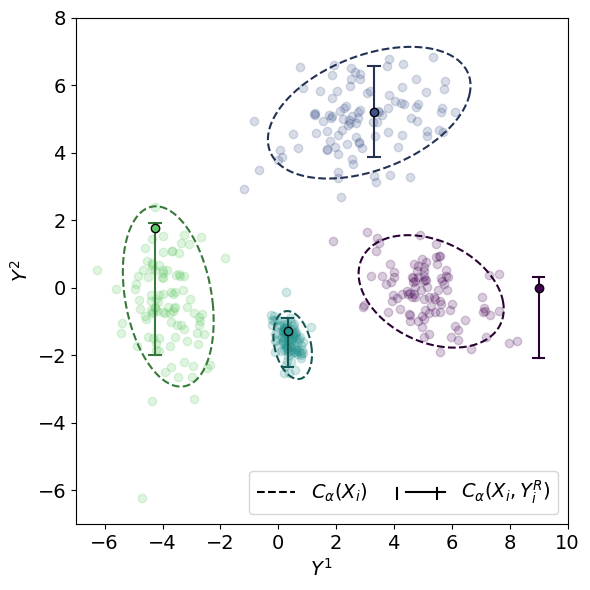

In [ ]:
tab_seed = [14, 18, 19, 55]
q_val = 2.0
dtype = torch.float32

coverage_emp = []

idx_unknown = np.setdiff1d(np.arange(k), idx_knowned) 

fig, ax = plt.subplots(figsize=(6, 6))


color_map = plt.cm.get_cmap('viridis', 5)
colors = color_map(np.linspace(0, 1, 5))
darker_colors = colors.copy()
from matplotlib.colors import ListedColormap
darker_viridis = ListedColormap(darker_colors)
darker_colors[:, :3] *= 0.6

for i, seed in enumerate(tab_seed): 
        seed_everything(seed)
        x_specific, y_specific = data_generator.generate_specific_x(100)

        if seed == 14:
                y_specific[0] = np.array([9.0, 0.0])

        x_specific_tensor = torch.tensor(x_specific, dtype=dtype)
        y_specific_tensor = torch.tensor(y_specific, dtype=dtype)

        centers = gaussian_level_sets.get_centers(x_specific_tensor)
        centers_np = centers.detach().numpy()
        Lambdas_specific = gaussian_level_sets.get_Lambdas(x_specific_tensor)
        Lambdas_specific_np = Lambdas_specific.detach().numpy()

        radius = gaussian_level_sets.nu_conformal.item()

        
        ax = add_ellipse(ax,  centers_np[0], Lambdas_specific_np[0], q_val, radius, color = darker_viridis(i), linestyle='--', label=None)
          
        coverage_emp.append(gaussian_level_sets.get_coverage(x_specific_tensor, y_specific_tensor))
        
        y_values = []
        for j in range(1):
                t = y_specific_tensor[j, 0]                
                for y in np.linspace(-10, 10, 10_000):  # Plage de valeurs pour y
                        t_y = torch.tensor([t, y], dtype = dtype).unsqueeze(0)                         
                        
                        y_r = t_y[:, idx_knowned]
                        y_s = t_y[:, idx_unknown]

                        inside = gaussian_level_sets.get_coverage_condition_on_idx(x_specific_tensor[[0]] ,t_y)

                        if inside:
                                y_values.append(y)


                ax.plot([t, t], [min(y_values), max(y_values)], color=darker_viridis(i),  label=None)
                ax.plot([t-0.2, t+0.2], [min(y_values), min(y_values)], label=None, color=darker_viridis(i))
                ax.plot([t-0.2, t+0.2], [max(y_values), max(y_values)], label=None, color=darker_viridis(i))
       
        ax.scatter(y_specific[:, 0], y_specific[:, 1], label=None, c = color_map(i), alpha = 0.2)
        ax.scatter(y_specific[0, 0], y_specific[0, 1], label=None, c = color_map(i), edgecolors='black', zorder=10)

ax = add_ellipse(ax,  centers_np[0] + np.array([100, 100]), Lambdas_specific_np[0], q_val, radius, color = "black", linestyle='--', label=fr'$C_\alpha(X_{{i}})$')
ax.plot([t, t], [min(y_values)+ 100, max(y_values)+100], color="black",  label=fr'$C_\alpha(X_{{i}}, Y_{{i}}^{{R}})$')

ax.set_xlabel(r'$Y^1$', fontsize=14)
ax.set_ylabel(r'$Y^2$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
leg = ax.legend(fontsize=14, loc='lower right', ncols=2)
ax.set_xlim(-7, 10)
ax.set_ylim(-7, 8)
leg.set_zorder(2)

ax.plot([4.1, 4.1], [-6.25, -5.95], color="black", zorder=3)
ax.plot([5.5, 5.5], [-6.25, -5.95], color="black", zorder=3)
        


plt.tight_layout()

plt.savefig(f"../figs/revealed_{pert}_level_sets_{coverage_emp[0]:.2f}_{coverage_emp[1]:.2f}_{coverage_emp[2]:.2f}_{coverage_emp[3]:.2f}.png", dpi = 300, bbox_inches='tight')
plt.savefig(f"../figs/revealed_{pert}_level_sets_{coverage_emp[0]:.2f}_{coverage_emp[1]:.2f}_{coverage_emp[2]:.2f}_{coverage_emp[3]:.2f}.pdf", dpi = 300, bbox_inches='tight')

plt.show()

plt.close()